# Select Top Cryptocurrencies Based on Spillover Effects

This notebook analyzes the spillover effects between cryptocurrencies and selects the top 20 with the most significant network effects.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add the project root to the path if needed
sys.path.append(os.path.abspath('../..'))

from src.utils.graph_utils import compute_spillover_index

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [2]:
# Load the cryptocurrency data
data = pd.read_csv('../../data/rv5_sqrt_38_crypto.csv', index_col=0) * 100
print(f"Loaded data with shape: {data.shape}")
print(f"Cryptocurrencies: {', '.join(data.columns.tolist()[:5])}... (and {len(data.columns)-5} more)")

Loaded data with shape: (1609, 38)
Cryptocurrencies: BTCUSDT, ETHUSDT, BCHUSDT, XRPUSDT, EOSUSDT... (and 33 more)


In [3]:
# Split into train for computing spillover index
train_end_idx = int(len(data.index) * 0.7)
train_data = data.iloc[:train_end_idx, :]
print(f"Training data shape: {train_data.shape}")

Training data shape: (1126, 38)


In [4]:
# Compute spillover index
horizon = 5
lag = 22
print(f"Computing spillover index with horizon={horizon}, lag={lag}...")
spillover_matrix = compute_spillover_index(train_data, horizon, lag, 0.0, standardized=True)
print("Spillover index computation complete.")

Computing spillover index with horizon=5, lag=22...
Spillover index computation complete.


In [5]:
# Create DataFrame with spillover matrix
crypto_names = train_data.columns.tolist()
spillover_df = pd.DataFrame(spillover_matrix, index=crypto_names, columns=crypto_names)

# Calculate total spillover effect for each cryptocurrency
# Sum of row (spillover to others) and column (spillover from others)
spillover_to_others = spillover_df.sum(axis=1)
spillover_from_others = spillover_df.sum(axis=0)
total_spillover = spillover_to_others + spillover_from_others

# Create ranking DataFrame
ranking = pd.DataFrame({
    'Crypto': crypto_names,
    'Spillover_To_Others': spillover_to_others.values,
    'Spillover_From_Others': spillover_from_others.values,
    'Total_Spillover': total_spillover.values
})

# Sort by total spillover
ranking = ranking.sort_values('Total_Spillover', ascending=False)
ranking.head(10)

,Crypto,Spillover_To_Others,Spillover_From_Others,Total_Spillover
2,BCHUSDT,49.974990,48.125017,98.100007
24,THETAUSDT,50.879430,46.842661,97.722092
4,EOSUSDT,45.703882,50.935717,96.639599
21,NEOUSDT,50.894533,45.426234,96.320767
13,ZECUSDT,49.496269,46.601110,96.097378
8,LINKUSDT,53.109729,41.048109,94.157838
22,QTUMUSDT,41.346583,52.724372,94.070955
17,ONTUSDT,49.080344,44.297855,93.378198
7,ETCUSDT,45.828018,47.405315,93.233333
20,VETUSDT,51.050622,40.765312,91.815934


## Visualize Spillover Effects

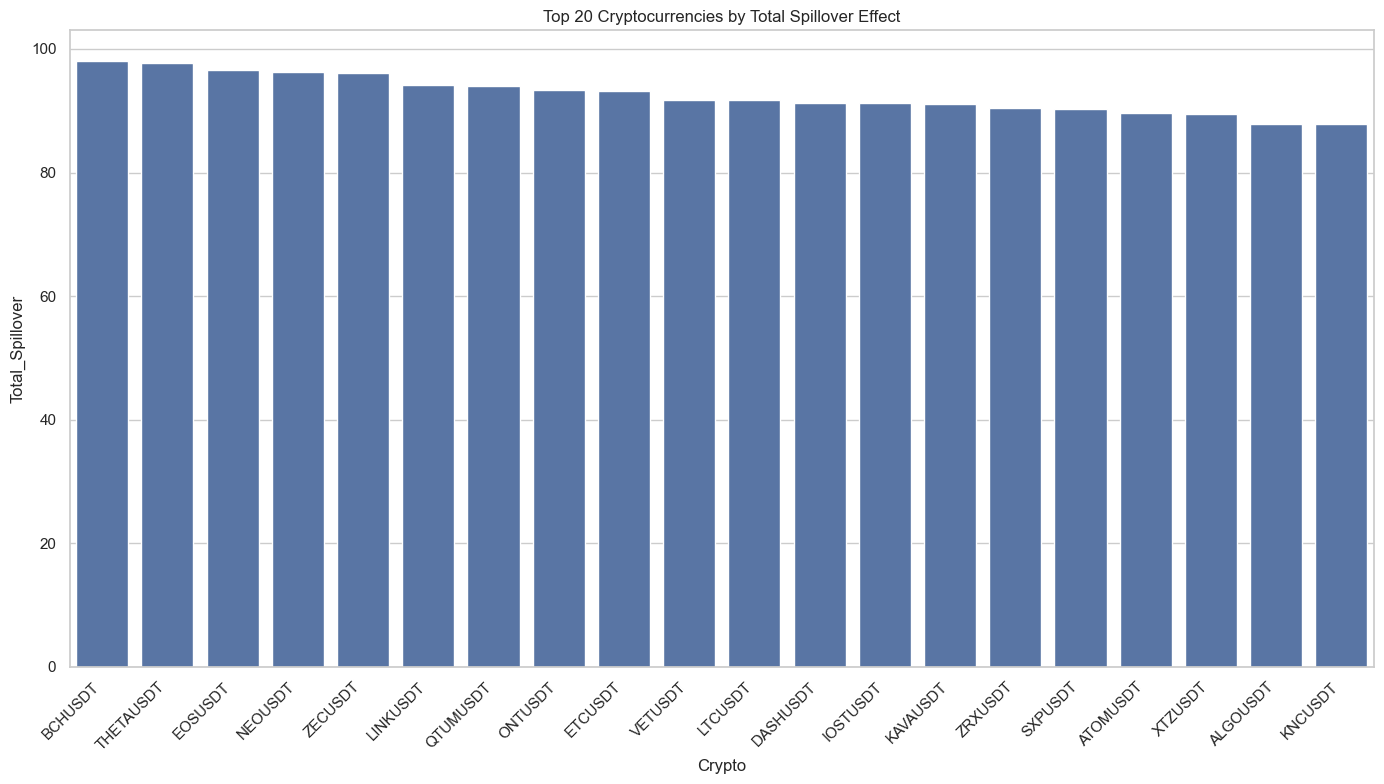

In [6]:
# Plot the top 20 cryptocurrencies by total spillover
plt.figure(figsize=(14, 8))
top_20 = ranking.iloc[:20]
sns.barplot(x='Crypto', y='Total_Spillover', data=top_20)
plt.title('Top 20 Cryptocurrencies by Total Spillover Effect')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/Users/DSK/miniforge3/envs/cenv_njs_main/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/DSK/miniforge3/envs/cenv_njs_main/lib/python3.11/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


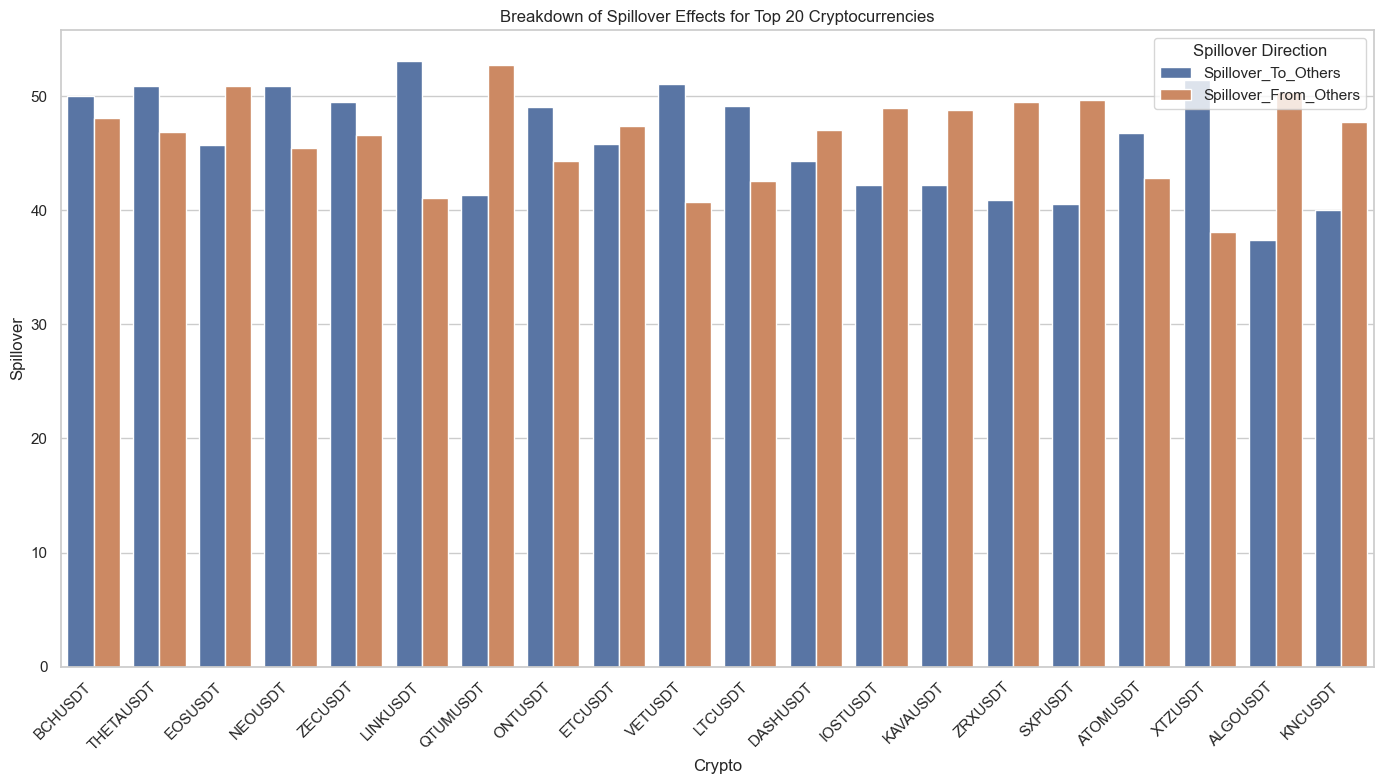

In [7]:
# Plot the breakdown of spillover effects (to others vs from others)
plt.figure(figsize=(14, 8))
top_20_melt = pd.melt(top_20[['Crypto', 'Spillover_To_Others', 'Spillover_From_Others']], 
                      id_vars=['Crypto'], 
                      value_vars=['Spillover_To_Others', 'Spillover_From_Others'],
                      var_name='Direction', value_name='Spillover')

sns.barplot(x='Crypto', y='Spillover', hue='Direction', data=top_20_melt)
plt.title('Breakdown of Spillover Effects for Top 20 Cryptocurrencies')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Spillover Direction')
plt.tight_layout()
plt.show()

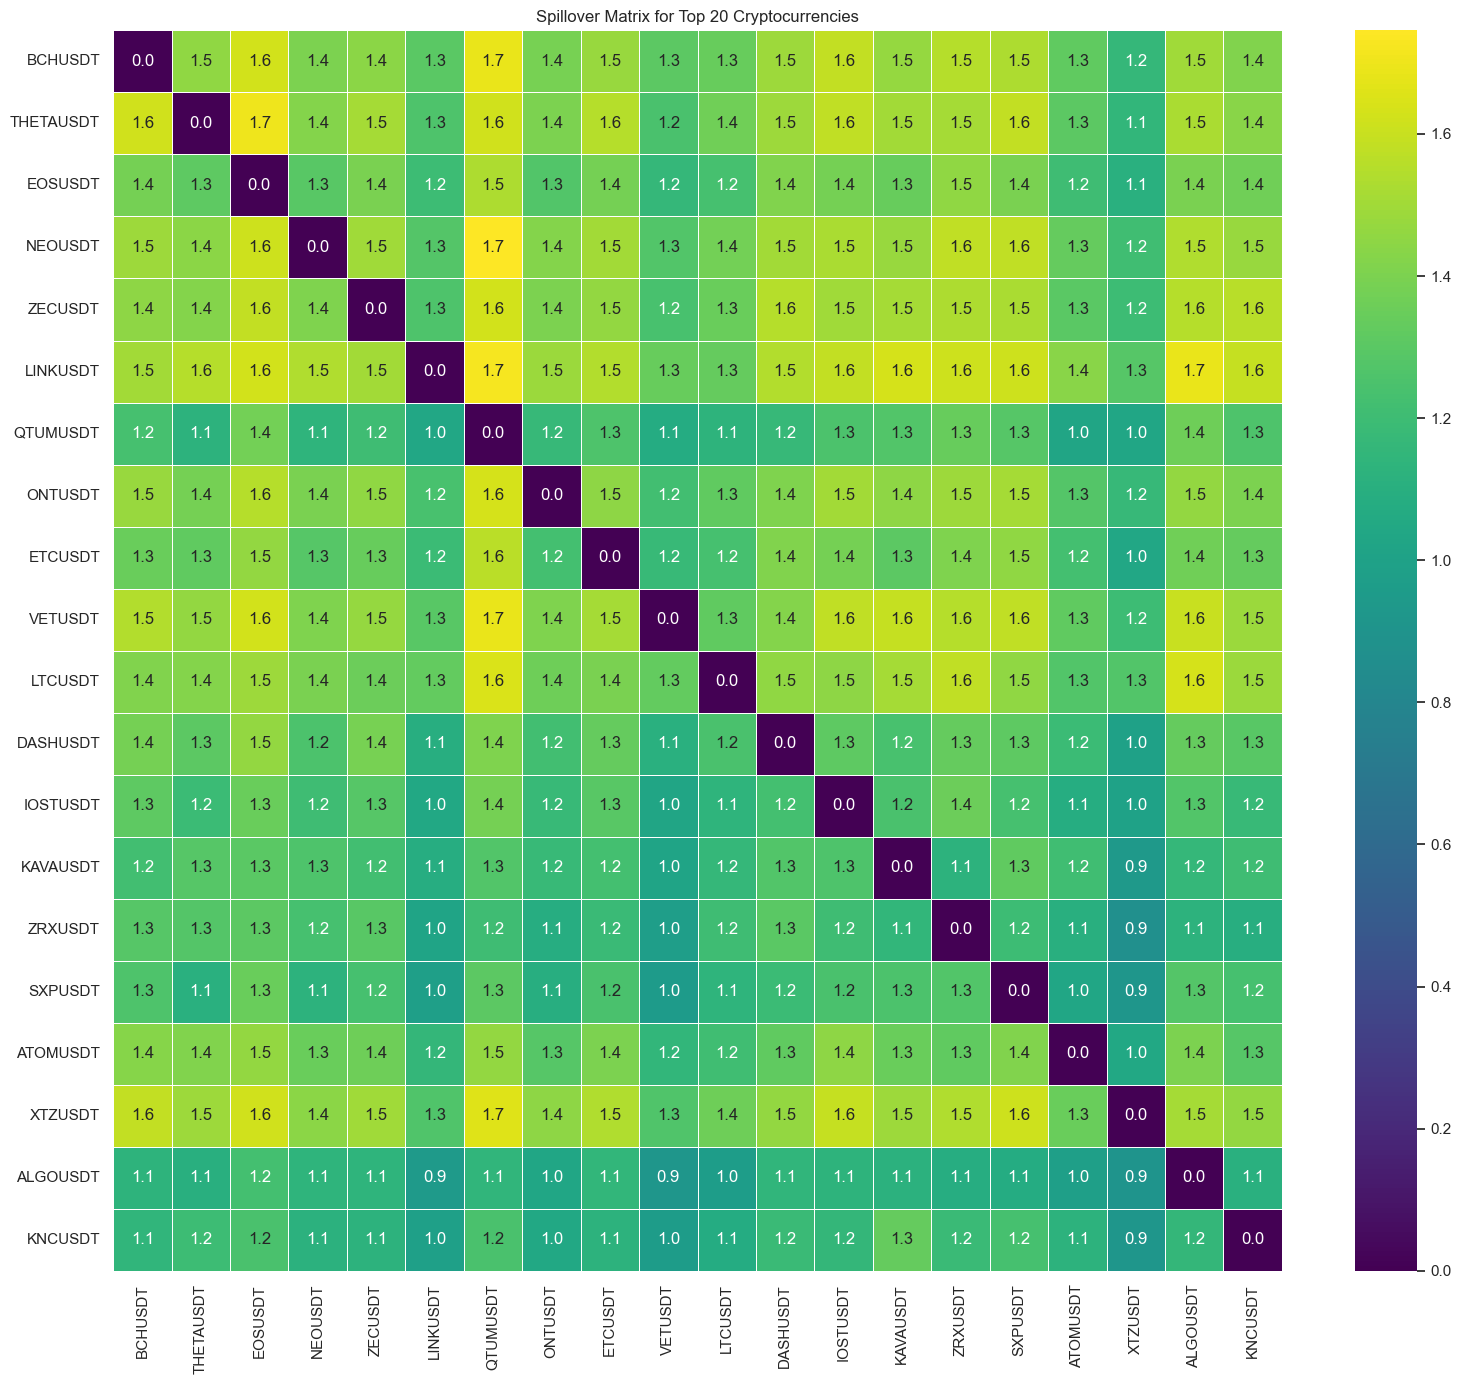

In [8]:
# Visualize the spillover matrix as a heatmap for the top 20
top_20_cryptos = ranking.iloc[:20]['Crypto'].tolist()
top_20_matrix = spillover_df.loc[top_20_cryptos, top_20_cryptos]

plt.figure(figsize=(16, 14))
sns.heatmap(top_20_matrix, annot=True, cmap='viridis', fmt='.1f', linewidths=0.5)
plt.title('Spillover Matrix for Top 20 Cryptocurrencies')
plt.tight_layout()
plt.show()

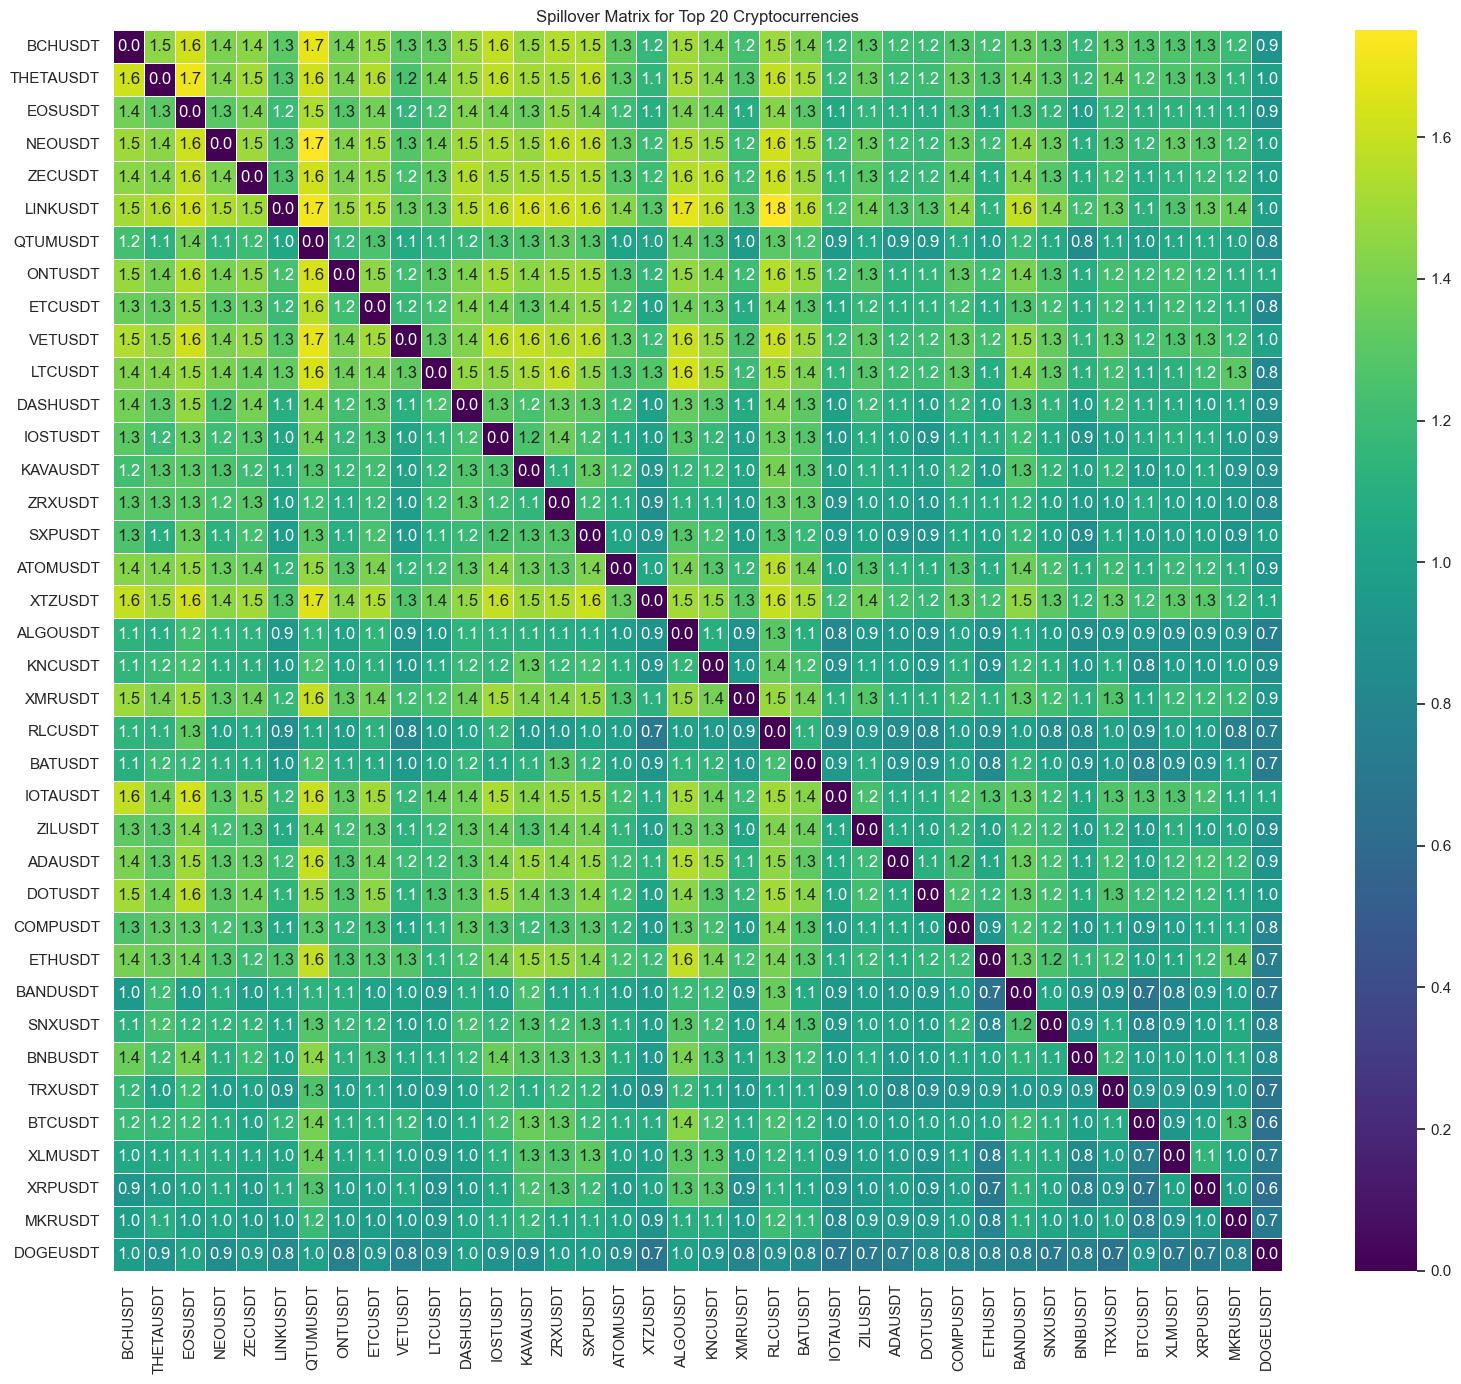

In [ ]:
# Visualize the spillover matrix as a heatmap for the top 20
top_all_cryptos = ranking['Crypto'].tolist()
top_all_matrix = spillover_df.loc[top_all_cryptos, top_all_cryptos]

plt.figure(figsize=(16, 14))
sns.heatmap(top_all_matrix, annot=True, cmap='viridis', fmt='.1f', linewidths=0.5)
plt.title('Spillover Matrix for All Cryptocurrencies')
plt.tight_layout()
plt.show()

In [9]:
# Select top 20 cryptocurrencies
top_20_cryptos = ranking.iloc[:20]['Crypto'].tolist()
print("Top 20 cryptocurrencies by spillover effect:")
for i, crypto in enumerate(top_20_cryptos, 1):
    print(f"{i}. {crypto}")

Top 20 cryptocurrencies by spillover effect:
1. BCHUSDT
2. THETAUSDT
3. EOSUSDT
4. NEOUSDT
5. ZECUSDT
6. LINKUSDT
7. QTUMUSDT
8. ONTUSDT
9. ETCUSDT
10. VETUSDT
11. LTCUSDT
12. DASHUSDT
13. IOSTUSDT
14. KAVAUSDT
15. ZRXUSDT
16. SXPUSDT
17. ATOMUSDT
18. XTZUSDT
19. ALGOUSDT
20. KNCUSDT


In [10]:
# Create new dataset with only the top 20
data_top20 = data[top_20_cryptos]

# Save to CSV
output_path = '../../data/rv5_sqrt_20_crypto.csv'
data_top20.to_csv(output_path)
print(f"Saved top 20 cryptocurrencies dataset to {output_path}")

Saved top 20 cryptocurrencies dataset to ../../data/rv5_sqrt_20_crypto.csv


## Network Visualization of Spillover Effects

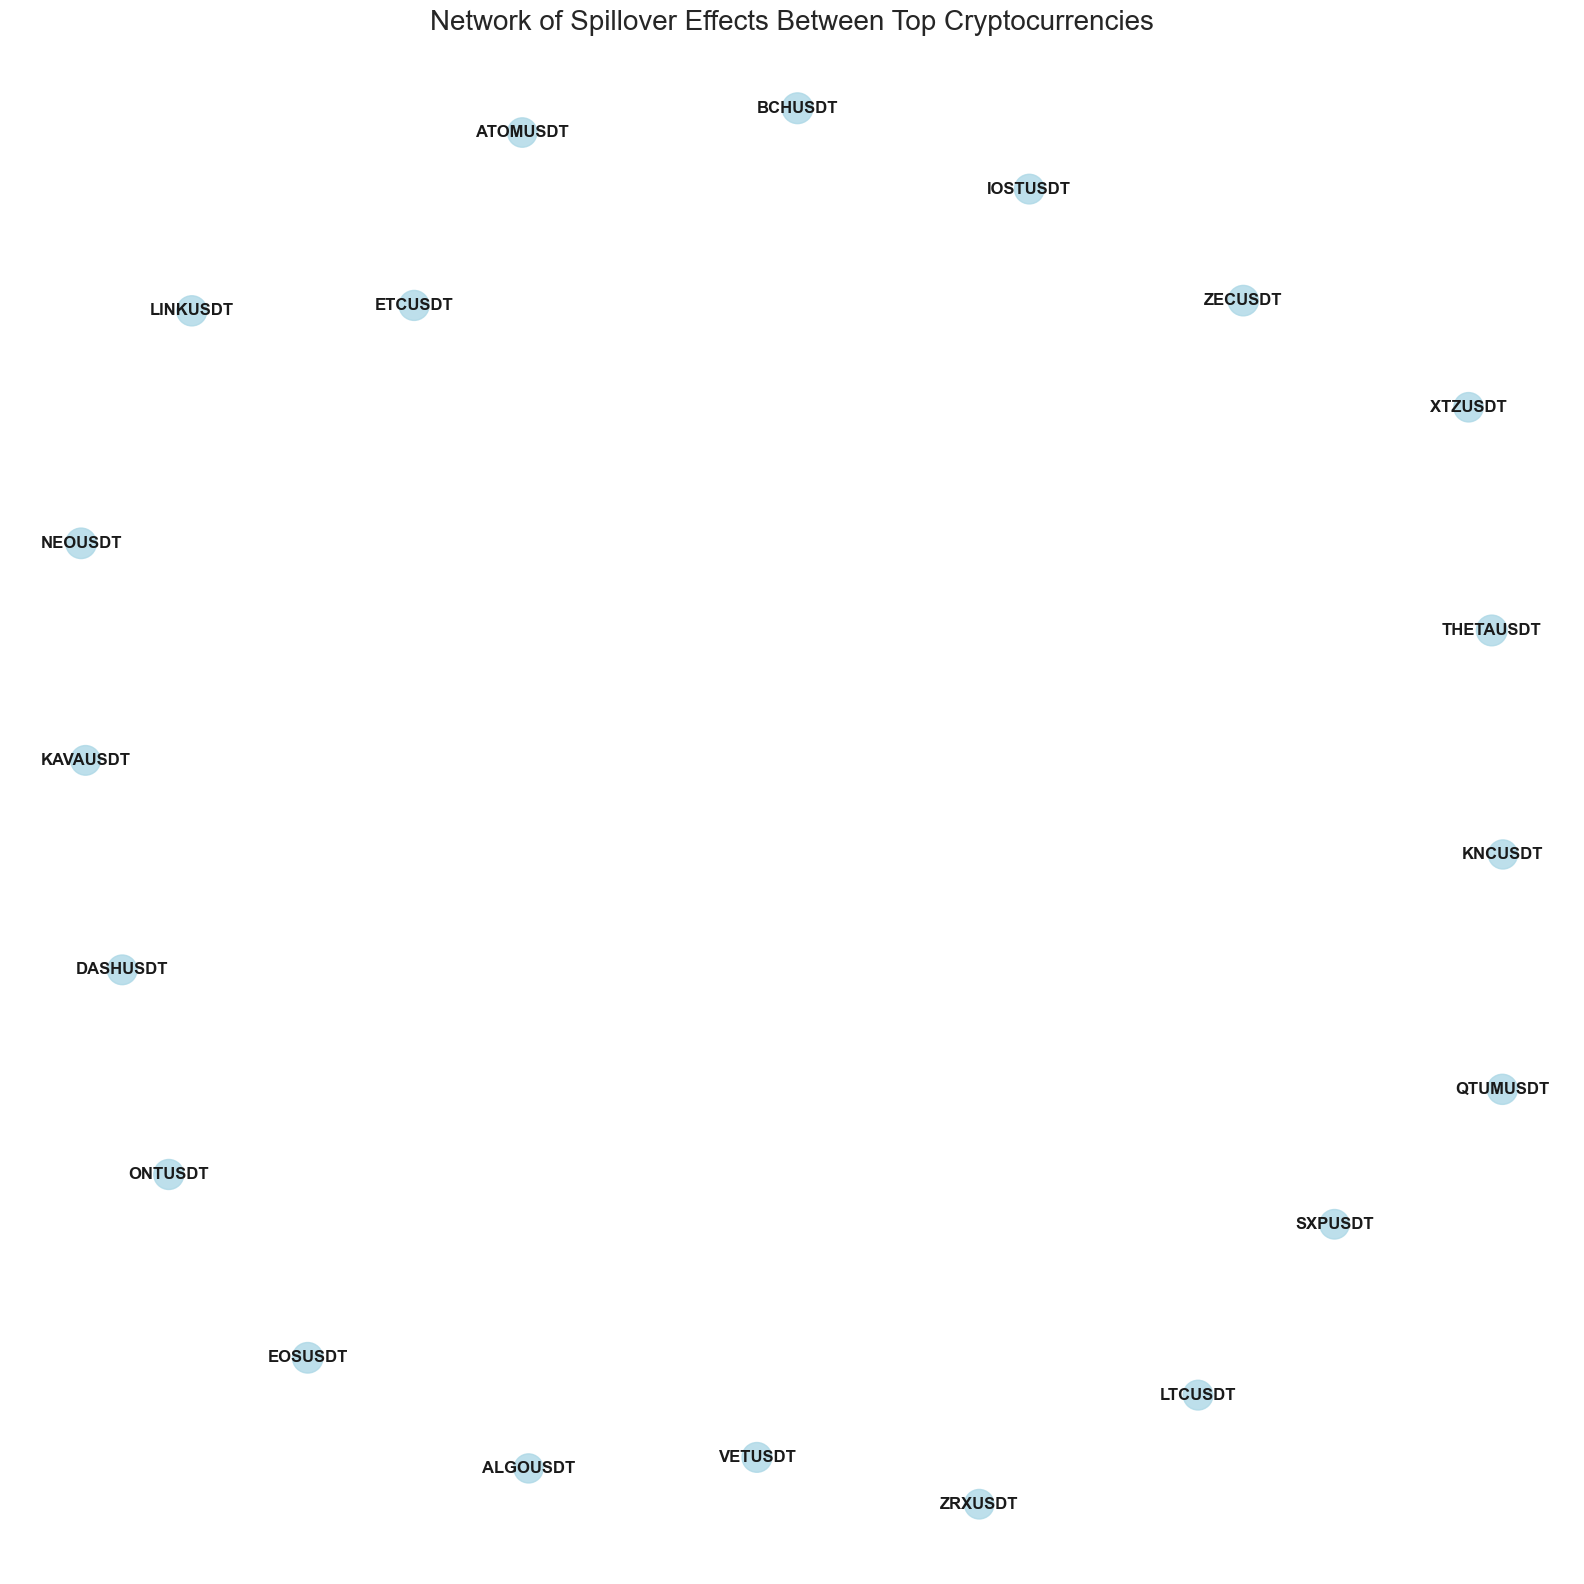

In [11]:
# Create a network visualization of the spillover effects
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes
for crypto in top_20_cryptos:
    G.add_node(crypto)

# Add edges with weights based on spillover values
for i, source in enumerate(top_20_cryptos):
    for j, target in enumerate(top_20_cryptos):
        if i != j:  # Skip self-loops
            weight = top_20_matrix.loc[source, target]
            if weight > 5:  # Only show significant connections
                G.add_edge(source, target, weight=weight)

# Calculate node sizes based on total spillover
node_sizes = {}
for crypto in top_20_cryptos:
    node_sizes[crypto] = ranking[ranking['Crypto'] == crypto]['Total_Spillover'].values[0] * 5

# Draw the network
plt.figure(figsize=(16, 16))
pos = nx.spring_layout(G, seed=42)  # Position nodes using force-directed layout

# Draw nodes
nx.draw_networkx_nodes(G, pos, 
                      node_size=[node_sizes[node] for node in G.nodes()],
                      node_color='lightblue',
                      alpha=0.8)

# Draw edges with varying width based on weight
edges = G.edges(data=True)
weights = [data['weight']/10 for _, _, data in edges]
nx.draw_networkx_edges(G, pos, width=weights, alpha=0.5, edge_color='gray', arrows=True, arrowsize=15)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

plt.title('Network of Spillover Effects Between Top Cryptocurrencies', fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.show()